# Multiple Linear Regression

# The steps in this exercise are as follows:
1. Reading, understanding and visualising the data
2. Preparing the data for modelling (train-test split, rescalling etc.)
3. Training the model
4. Residual analysis
5. Predictions and evaluation on the test set

# Step 1: Reading and Understanding the Data
Let us first import NumPy and Pandas and read the housing dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the data

housing = pd.read_excel('50_Startups.xlsx')
housing.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [3]:
housing.shape

(50, 5)

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [5]:
housing.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


## Visualise the data

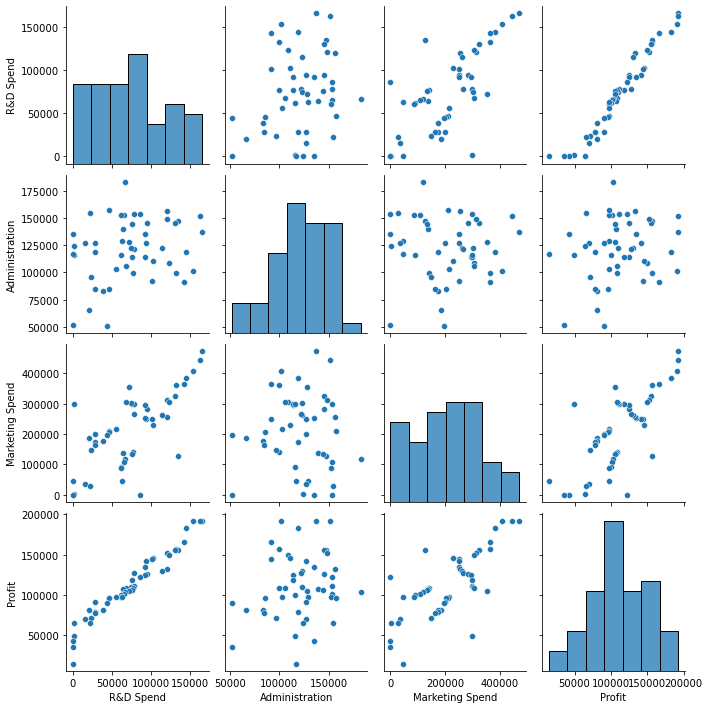

In [6]:
# Visualising the numeric variables

sns.pairplot(housing)
plt.show()

In [7]:
housing.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


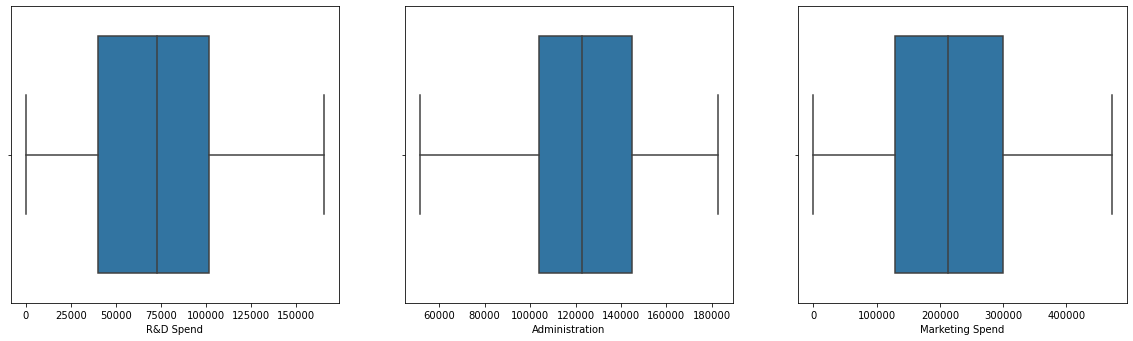

In [8]:
# Visualising the categorical variables

plt.figure(figsize=[20,12])
plt.subplot(2,3,1)
sns.boxplot(housing['R&D Spend'])
plt.subplot(2,3,2)
sns.boxplot(housing['Administration'])
plt.subplot(2,3,3)
sns.boxplot(housing['Marketing Spend'])
plt.show()

## Step 2: Preparing the Data for Moelling

- Encoding:
    - Converting binary vars to 1/0
    - Other categorical vars to dummy vars
- Splitting into train and test
- Rescaling of variables

In [9]:
housing.columns

Index(['R&D Spend', 'Administration', 'Marketing Spend', 'State', 'Profit'], dtype='object')

In [10]:
housing.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [11]:
housing.State.unique()

array(['New York', 'California', 'Florida'], dtype=object)

## Dummy variables

In [12]:
# creating dummy varialbes for furnishing status

status = pd.get_dummies(housing['State'])
status.head()

,California,Florida,New York
0,0,0,1
1,1,0,0
2,0,1,0
3,0,0,1
4,0,1,0


Now, you don't need three columns. You can drop the furnished column, as the type of furnishing can be identified with just the last two columns where —

- 00 will correspond to furnished
- 01 will correspond to unfurnished
- 10 will correspond to semi-furnished

In [13]:

# dropping a redundant dummy variable

status = pd.get_dummies(housing['State'], drop_first=True)
status.head()

,Florida,New York
0,0,1
1,0,0
2,1,0
3,0,1
4,1,0


In [14]:
# concat the dummy df with the original one

housing = pd.concat([housing, status], axis=1)
housing.head()

,R&D Spend,Administration,Marketing Spend,State,Profit,Florida,New York
0,165349.20,136897.80,471784.10,New York,192261.83,0,1
1,162597.70,151377.59,443898.53,California,191792.06,0,0
2,153441.51,101145.55,407934.54,Florida,191050.39,1,0
3,144372.41,118671.85,383199.62,New York,182901.99,0,1
4,142107.34,91391.77,366168.42,Florida,166187.94,1,0


In [15]:
# dropping the 'furnishingstatus' variable post converting it to dummy variable

housing = housing.drop('State', axis=1)
housing.head()

,R&D Spend,Administration,Marketing Spend,Profit,Florida,New York
0,165349.20,136897.80,471784.10,192261.83,0,1
1,162597.70,151377.59,443898.53,191792.06,0,0
2,153441.51,101145.55,407934.54,191050.39,1,0
3,144372.41,118671.85,383199.62,182901.99,0,1
4,142107.34,91391.77,366168.42,166187.94,1,0


## Splitting into train and test

In [16]:
# splitting train and test

df_train, df_test = train_test_split(housing, train_size=0.7, random_state=100)

print(df_train.shape)
print(df_test.shape)

(35, 6)
(15, 6)


### Rescaling the Features 

As you saw in the demonstration for Simple Linear Regression, scaling doesn't impact your model. Here we can see that except for `area`, all the columns have small integer values. So it is extremely important to rescale the variables so that they have a comparable scale. If we don't have comparable scales, then some of the coefficients as obtained by fitting the regression model might be very large or very small as compared to the other coefficients. This might become very annoying at the time of model evaluation. So it is advised to use standardization or normalization so that the units of the coefficients obtained are all on the same scale. As you know, there are two common ways of rescaling:

1. Min-Max scaling (normalisation): between 0 and 1
2. Standardisation (mean-0, sigma-1) 

This time, we will use MinMax scaling.

In [17]:
# fit(): learns xmin, xmax
# transform(): x-xmin / xmax-xmin

# fit_transform()

In [18]:
# 1. Instantiate an object

scaler = MinMaxScaler()

# create a list of numeric variables

num_vars = ['R&D Spend', 'Administration', 'Marketing Spend', 'Profit']

# 2. Fit on data
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

df_train.head()

,R&D Spend,Administration,Marketing Spend,Profit,Florida,New York
25,0.397698,0.828781,0.310798,0.459464,0,0
26,0.463284,0.872035,0.301984,0.448762,1,0
35,0.282993,0.314337,0.462983,0.389486,0,1
17,0.582156,0.880923,0.636574,0.574544,0,1
7,0.801353,0.885193,0.729619,0.769153,1,0


In [19]:
df_train[num_vars].describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,35.000000,35.000000,35.000000,35.000000
mean,0.479871,0.689748,0.489092,0.508198
std,0.265304,0.244887,0.273648,0.246458
min,0.000000,0.000000,0.000000,0.000000
25%,0.330763,0.546419,0.306391,0.393271
50%,0.463284,0.713324,0.562830,0.467981
75%,0.665559,0.900242,0.684940,0.655098
max,1.000000,1.000000,1.000000,1.000000


## Step 3: Training the Model

### 3.1 Building forward selection model
- Adding variables one by one and till we get a good model

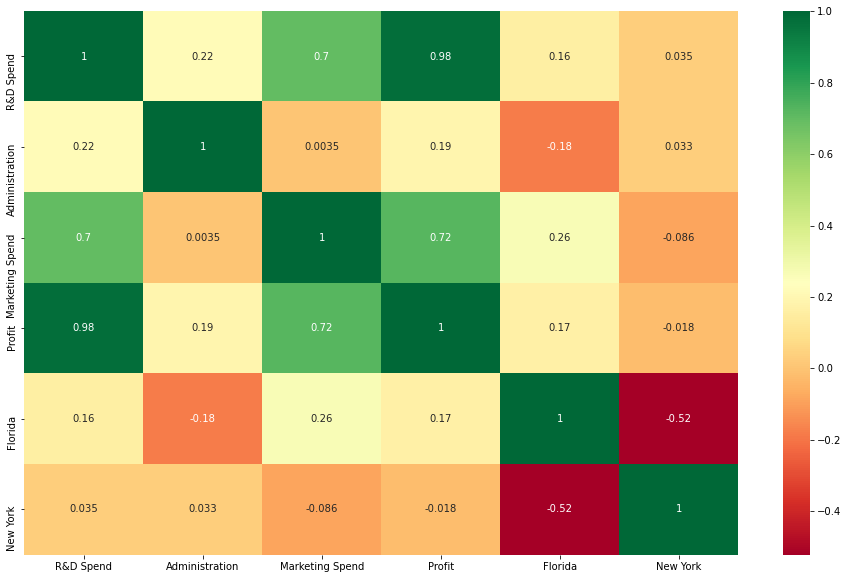

In [20]:
# heatmap

plt.figure(figsize=[16,10])
sns.heatmap(df_train.corr(), annot=True, cmap='RdYlGn')
plt.show()

In [21]:
# x_train, y_train

y_train = df_train.pop('Profit')
x_train = df_train

In [22]:
x_train.head()

,R&D Spend,Administration,Marketing Spend,Florida,New York
25,0.397698,0.828781,0.310798,0,0
26,0.463284,0.872035,0.301984,1,0
35,0.282993,0.314337,0.462983,0,1
17,0.582156,0.880923,0.636574,0,1
7,0.801353,0.885193,0.729619,1,0


In [23]:
y_train.head()

25    0.459464
26    0.448762
35    0.389486
17    0.574544
7     0.769153
Name: Profit, dtype: float64

- significance of variable
- VIF

In [24]:
# add a constant

x_train_sm = sm.add_constant(x_train['R&D Spend'])

# create first model

lr = sm.OLS(y_train, x_train_sm)

# fit

lr_model = lr.fit()

# params

lr_model.params

const        0.071419
R&D Spend    0.910201
dtype: float64

In [25]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     792.2
Date:                Thu, 24 Mar 2022   Prob (F-statistic):           1.20e-24
Time:                        22:15:58   Log-Likelihood:                 56.199
No. Observations:                  35   AIC:                            -108.4
Df Residuals:                      33   BIC:                            -105.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0714      0.018      4.041      0.000       0.035       0.107
R&D Spend      0.9102      0.032     28.147      0.000       0.844       0.976
==============================================================================
Omnibus:                        1.025   Durbin-Watson:                   2.584
Prob(Omnibus):                  0.599   Jarque-Bera (JB):                0.682
Skew:                          -0.341   Prob(JB):                        0.711
Kurtosis:                       2.939   Cond. No.                         4.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
# add another variable bathooms

x_train_sm = x_train[['R&D Spend', 'Administration']]
x_train_sm = sm.add_constant(x_train_sm)
lr = sm.OLS(y_train, x_train_sm)
lr_model = lr.fit()
lr_model.params

const             0.084856
R&D Spend         0.914729
Administration   -0.022631
dtype: float64

In [27]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     389.0
Date:                Thu, 24 Mar 2022   Prob (F-statistic):           3.52e-23
Time:                        22:15:59   Log-Likelihood:                 56.411
No. Observations:                  35   AIC:                            -106.8
Df Residuals:                      32   BIC:                            -102.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0849      0.028      3.037      0.005       0.028       0.142
R&D Spend          0.9147      0.033     27.358      0.000       0.847       0.983
Administration    -0.0226      0.036     -0.625      0.537      -0.096       0.051
==============================================================================
Omnibus:                        1.396   Durbin-Watson:                   2.624
Prob(Omnibus):                  0.498   Jarque-Bera (JB):                0.979
Skew:                          -0.409   Prob(JB):                        0.613
Kurtosis:                       2.943   Cond. No.                         6.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
# add another variable bedrooms

x_train_sm = x_train[['R&D Spend', 'Administration', 'Marketing Spend']]
x_train_sm = sm.add_constant(x_train_sm)
lr = sm.OLS(y_train, x_train_sm)
lr_model = lr.fit()
lr_model.params

const              0.067862
R&D Spend          0.862853
Administration    -0.010719
Marketing Spend    0.068847
dtype: float64

In [29]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     271.7
Date:                Thu, 24 Mar 2022   Prob (F-statistic):           2.46e-22
Time:                        22:15:59   Log-Likelihood:                 57.732
No. Observations:                  35   AIC:                            -107.5
Df Residuals:                      31   BIC:                            -101.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0679      0.029      2.306      0.028       0.008       0.128
R&D Spend           0.8629      0.047     18.490      0.000       0.768       0.958
Administration     -0.0107      0.036     -0.296      0.769      -0.085       0.063
Marketing Spend     0.0688      0.044      1.559      0.129      -0.021       0.159
==============================================================================
Omnibus:                        1.027   Durbin-Watson:                   2.521
Prob(Omnibus):                  0.598   Jarque-Bera (JB):                0.818
Skew:                          -0.363   Prob(JB):                        0.664
Kurtosis:                       2.818   Cond. No.                         10.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 3.2 Building reverse selection model
- Adding all variables to the model and keep removing one by one

In [30]:
housing.columns

Index(['R&D Spend', 'Administration', 'Marketing Spend', 'Profit', 'Florida',
       'New York'],
      dtype='object')

In [31]:
# build a model with all vairalbes

x_train_sm = sm.add_constant(x_train)

lr = sm.OLS(y_train, x_train_sm)

lr_model = lr.fit()

lr_model.params

const              0.088197
R&D Spend          0.875768
Administration    -0.018963
Marketing Spend    0.064732
Florida           -0.021040
New York          -0.033893
dtype: float64

In [32]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     167.1
Date:                Thu, 24 Mar 2022   Prob (F-statistic):           1.87e-20
Time:                        22:15:59   Log-Likelihood:                 59.275
No. Observations:                  35   AIC:                            -106.5
Df Residuals:                      29   BIC:                            -97.22
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0882      0.032      2.741      0.010       0.022       0.154
R&D Spend           0.8758      0.047     18.696      0.000       0.780       0.972
Administration     -0.0190      0.037     -0.515      0.610      -0.094       0.056
Marketing Spend     0.0647      0.044      1.455      0.156      -0.026       0.156
Florida            -0.0210      0.022     -0.971      0.340      -0.065       0.023
New York           -0.0339      0.021     -1.630      0.114      -0.076       0.009
==============================================================================
Omnibus:                        0.515   Durbin-Watson:                   2.640
Prob(Omnibus):                  0.773   Jarque-Bera (JB):                0.388
Skew:                          -0.245   Prob(JB):                        0.824
Kurtosis:                       2.840   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
# Deside which variable is to be removed based on the below considerations
# significance (p-values)
# VIF

### Compute the VIF

Checking VIF
Variance Inflation Factor or VIF, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model. The formula for calculating VIF is:

𝑉𝐼𝐹𝑖=1/(1−𝑅𝑖2)

In [34]:
# create a dataframe that will contain the names of all the feature variables and their respective VIFs

vif = pd.DataFrame()
vif['Features'] = x_train.columns
vif['VIF'] = [variance_inflation_factor(x_train.values, i) for i in range (x_train.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending=False)
vif

,Features,VIF
0,R&D Spend,9.54
2,Marketing Spend,8.12
1,Administration,4.32
3,Florida,2.03
4,New York,1.87


### we could have :
- High p-value, high VIF: Remove
- High - Low
    - Hig P , Low VIF : remove these first
    - Low p, high VIF : remove these after the ones above
- Low p, Low VIF: Keep

In [35]:
x = x_train.drop('Administration', axis=1)

In [36]:
# create another model

x_train_sm = sm.add_constant(x)

lr = sm.OLS(y_train, x_train_sm)

lr_model = lr.fit()

lr_model.params

const              0.075432
R&D Spend          0.868228
Marketing Spend    0.068820
Florida           -0.018559
New York          -0.032572
dtype: float64

In [37]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     214.1
Date:                Thu, 24 Mar 2022   Prob (F-statistic):           1.36e-21
Time:                        22:15:59   Log-Likelihood:                 59.115
No. Observations:                  35   AIC:                            -108.2
Df Residuals:                      30   BIC:                            -100.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0754      0.020      3.718      0.001       0.034       0.117
R&D Spend           0.8682      0.044     19.754      0.000       0.778       0.958
Marketing Spend     0.0688      0.043      1.592      0.122      -0.019       0.157
Florida            -0.0186      0.021     -0.889      0.381      -0.061       0.024
New York           -0.0326      0.020     -1.598      0.120      -0.074       0.009
==============================================================================
Omnibus:                        0.552   Durbin-Watson:                   2.602
Prob(Omnibus):                  0.759   Jarque-Bera (JB):                0.256
Skew:                          -0.209   Prob(JB):                        0.880
Kurtosis:                       2.988   Cond. No.                         9.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
vif = pd.DataFrame()
vif['Features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range (x.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending=False)
vif

,Features,VIF
0,R&D Spend,8.07
1,Marketing Spend,8.02
2,Florida,2.01
3,New York,1.73


In [39]:
x = x.drop('Florida', axis=1)

In [40]:
# create another model

x_train_sm = sm.add_constant(x)

lr = sm.OLS(y_train, x_train_sm)

lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     287.1
Date:                Thu, 24 Mar 2022   Prob (F-statistic):           1.08e-22
Time:                        22:15:59   Log-Likelihood:                 58.660
No. Observations:                  35   AIC:                            -109.3
Df Residuals:                      31   BIC:                            -103.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0696      0.019      3.637      0.001       0.031       0.109
R&D Spend           0.8665      0.044     19.801      0.000       0.777       0.956
Marketing Spend     0.0628      0.043      1.476      0.150      -0.024       0.150
New York           -0.0232      0.017     -1.334      0.192      -0.059       0.012
==============================================================================
Omnibus:                        1.308   Durbin-Watson:                   2.507
Prob(Omnibus):                  0.520   Jarque-Bera (JB):                0.737
Skew:                          -0.352   Prob(JB):                        0.692
Kurtosis:                       3.095   Cond. No.                         8.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
vif = pd.DataFrame()
vif['Features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range (x.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending=False)
vif

,Features,VIF
0,R&D Spend,7.92
1,Marketing Spend,7.41
2,New York,1.39


In [42]:
x = x.drop('New York', axis=1)

In [43]:
# create another model

x_train_sm = sm.add_constant(x)

lr = sm.OLS(y_train, x_train_sm)

lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     419.5
Date:                Thu, 24 Mar 2022   Prob (F-statistic):           1.10e-23
Time:                        22:15:59   Log-Likelihood:                 57.683
No. Observations:                  35   AIC:                            -109.4
Df Residuals:                      32   BIC:                            -104.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0611      0.018      3.346      0.002       0.024       0.098
R&D Spend           0.8587      0.044     19.564      0.000       0.769       0.948
Marketing Spend     0.0716      0.043      1.682      0.102      -0.015       0.158
==============================================================================
Omnibus:                        0.947   Durbin-Watson:                   2.510
Prob(Omnibus):                  0.623   Jarque-Bera (JB):                0.722
Skew:                          -0.343   Prob(JB):                        0.697
Kurtosis:                       2.847   Cond. No.                         8.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
vif = pd.DataFrame()
vif['Features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range (x.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending=False)
vif

,Features,VIF
0,R&D Spend,7.4
1,Marketing Spend,7.4


In [45]:
x = x.drop('Marketing Spend', axis=1)

In [46]:
# create another model

x_train_sm = sm.add_constant(x)

lr = sm.OLS(y_train, x_train_sm)

lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     792.2
Date:                Thu, 24 Mar 2022   Prob (F-statistic):           1.20e-24
Time:                        22:15:59   Log-Likelihood:                 56.199
No. Observations:                  35   AIC:                            -108.4
Df Residuals:                      33   BIC:                            -105.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0714      0.018      4.041      0.000       0.035       0.107
R&D Spend      0.9102      0.032     28.147      0.000       0.844       0.976
==============================================================================
Omnibus:                        1.025   Durbin-Watson:                   2.584
Prob(Omnibus):                  0.599   Jarque-Bera (JB):                0.682
Skew:                          -0.341   Prob(JB):                        0.711
Kurtosis:                       2.939   Cond. No.                         4.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Step 4: Residual analysis

In [47]:
y_train_pred = lr_model.predict(x_train_sm)
y_train_pred.head()

25    0.433404
26    0.493101
35    0.329000
17    0.601298
7     0.800811
dtype: float64

In [48]:
res = y_train - y_train_pred

<AxesSubplot:ylabel='Density'>

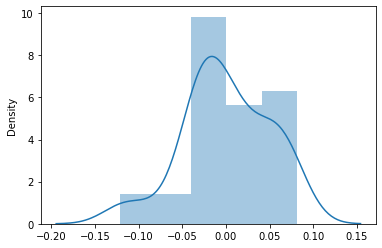

In [49]:
sns.distplot(res)

## Step 5: Predictions and evaluations on the test set

In [50]:
# create a list of numeric variables

num_vars = ['area', 'bedrooms', 'stories', 'parking', 'price','bathrooms']

# 2. Fit on data
df_test[num_vars] = scaler.transform(df_test[num_vars])

df_test.head()

KeyError: "None of [Index(['area', 'bedrooms', 'stories', 'parking', 'price', 'bathrooms'], dtype='object')] are in the [columns]"

In [ ]:
df_test.describe()

- Note: above, min value is from training set and max value is from test set

In [ ]:
y_test = df_test.pop('price')
x_test = df_test

In [ ]:
# add consitant

x_test_sm = sm.add_constant(x_test)
x_test_sm.head()

In [ ]:
x_test_sm = x_test_sm.drop(['bedrooms', 'semi-furnished'], axis = 1)

In [ ]:
# predict

y_test_pred = lr_model.predict(x_test_sm)
y_test_pred.head()

In [ ]:
# evaluate the model

r2_score(y_true=y_test, y_pred = y_test_pred)

- Nonte:: aove r2 score is almost the same to the r2 value that was found in training model
    - training model :: 0.681
    - test model :: 0.671
- So, finally our model is perfect

We can see that the equation of our best fitted line is:

𝑝𝑟𝑖𝑐𝑒=0.236×𝑎𝑟𝑒𝑎+0.202×𝑏𝑎𝑡ℎ𝑟𝑜𝑜𝑚𝑠+0.11×𝑠𝑡𝑜𝑟𝑖𝑒𝑠+0.05×𝑚𝑎𝑖𝑛𝑟𝑜𝑎𝑑+0.04×𝑔𝑢𝑒𝑠𝑡𝑟𝑜𝑜𝑚+0.0876×ℎ𝑜𝑡𝑤𝑎𝑡𝑒𝑟ℎ𝑒𝑎𝑡𝑖𝑛𝑔+0.0682×𝑎𝑖𝑟𝑐𝑜𝑛𝑑𝑖𝑡𝑖𝑜𝑛𝑖𝑛𝑔
+0.0629×𝑝𝑎𝑟𝑘𝑖𝑛𝑔+0.0637×𝑝𝑟𝑒𝑓𝑎𝑟𝑒𝑎−0.0337×𝑢𝑛𝑓𝑢𝑟𝑛𝑖𝑠ℎ𝑒𝑑

Overall we have a decent model, but we also acknowledge that we could do better.

We have a couple of options:

1. Add new features (bathrooms/bedrooms, area/stories, etc.)
2. Build a non-linear model